# 1. Imports and setup

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d sachinkumar413/alzheimer-mri-dataset

 61% 17.0M/28.0M [00:00<00:00, 49.9MB/s]
100% 28.0M/28.0M [00:00<00:00, 63.1MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/alzheimer-mri-dataset.zip')
zip_ref.extractall('/content/Data')
zip_ref.close()

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os
import pathlib
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing import image_dataset_from_directory
import itertools

In [5]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
for dirpath, dirnames, filenames in os.walk("/kaggle/input"):
    print(f"{len(dirnames)} dirs and {len(filenames)} images in '{dirpath}'")

In [6]:
data_dir = "/content/Data/Dataset/"
path_dir = pathlib.Path("/content/Data/Dataset/")
class_names = np.array(sorted([item.name for item in path_dir.glob('*')]))
print(class_names)

['Mild_Demented' 'Moderate_Demented' 'Non_Demented' 'Very_Mild_Demented']


# 2. Explore individual images

In [7]:
def view_random_image(target_dir, target_class):
    target_folder = target_dir + target_class
    random_image = random.sample(os.listdir(target_folder), 1)
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off");

    print(f"Image shape: {img.shape}")
    return img

Image shape: (128, 128)


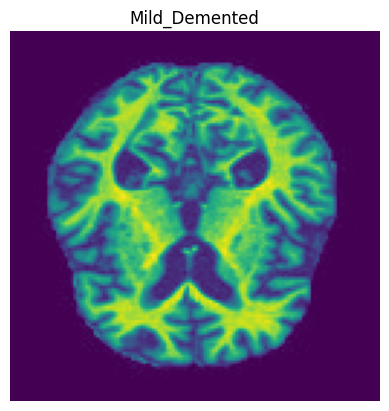

In [8]:
img = view_random_image(data_dir, class_names[0])

Image shape: (128, 128)


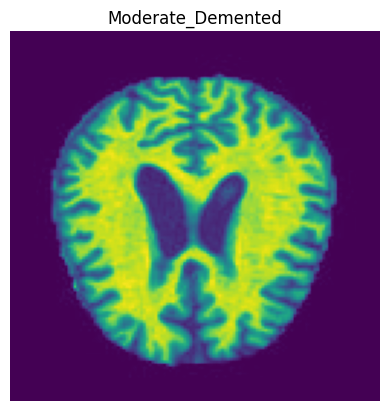

In [9]:
img = view_random_image(data_dir, class_names[1])

Image shape: (128, 128)


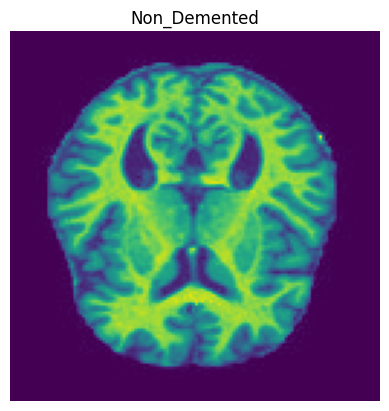

In [10]:
img = view_random_image(data_dir, class_names[2])

Image shape: (128, 128)


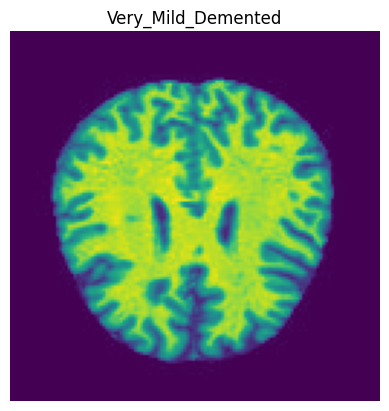

In [11]:
img = view_random_image(data_dir, class_names[3])

# 3. Model Tuning

## Split and preprocess data

In [12]:
# For replicable results
SEED = 0
# Size of the images is (128,128)
IMAGE_SIZE = (128, 128)
# Default batch size
BATCH_SIZE = 32
# Images are grayscale
COLOR_MODE = "grayscale"
# 20% test split
VAL_SPLIT = 0.2

tf.random.set_seed(SEED)
np.random.seed(SEED)
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    label_mode='categorical',
    validation_split=VAL_SPLIT,
    subset="training",
    seed=SEED,
    color_mode=COLOR_MODE,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)
valid_data = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=VAL_SPLIT,
    subset="validation",
    label_mode='categorical',
    seed=SEED,
    color_mode=COLOR_MODE,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

Found 6400 files belonging to 4 classes.
Using 5120 files for training.
Found 6400 files belonging to 4 classes.
Using 1280 files for validation.


## Model creation and compilation (EfficientNet B0)

In [13]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = True
inputs = tf.keras.layers.Input(shape=(IMAGE_SIZE+(1,)), name="input_layer")
# Efficient net model has the normalizing layer builtin
x = base_model(inputs)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = tf.keras.layers.Dense(len(class_names), activation="softmax", name="output_layer")(x)

16705208/16705208 [==============================] - 0s 0us/step


In [14]:
model = tf.keras.Model(inputs, outputs)

In [15]:
# Default Learning rate
LR = 0.001

model.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
                metrics=["accuracy"])

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 128, 128, 1)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 4)                 5124      
                                                                 
Total params: 4054695 (15.47 MB)
Trainable params: 4012672 (15.31 MB)
Non-trainable params: 42023 (164.16 KB)
_________________

## Fit and evaluate model

In [17]:
# Epochs
EPOCHS = 50
history = model.fit(train_data,
                      validation_data=valid_data,
                      epochs=EPOCHS,
                      verbose=False
                      )

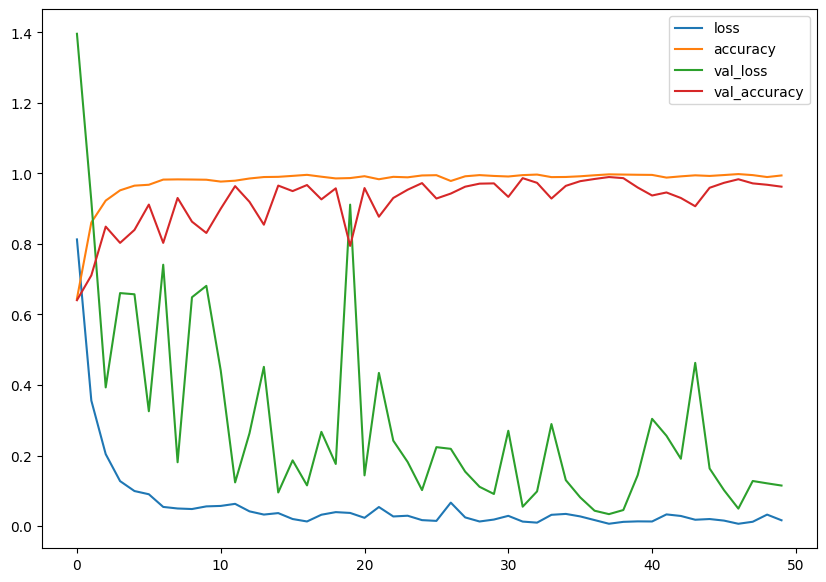

In [18]:
pd.DataFrame(history.history).plot(figsize=(10, 7));

In [19]:
model.evaluate(valid_data)

40/40 [==============================] - 1s 24ms/step - loss: 0.1149 - accuracy: 0.9625


[0.11487309634685516, 0.9624999761581421]

In [20]:
model.save('alzheimer.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# 4. Final thoughts

The accuracy on unseen images is around 99%. This is a significantly better result than the previous version of this notebook, with a 75% accuracy.

What was the big change? Simply make the Efficientnet model trainable from start. The course I was following until now mentiones it's best to train your model first without making it trainable, then make the last layers trainable and compare results. Thanks to Gerry (gpiosenka) beating me to a pulp in my color polygon dataset I learned it's actually best to make the model trainable from the start, it's worth it **a lot**.